# Transfer Learning Thesis

https://thedatafrog.com/en/articles/image-recognition-transfer-learning/

## Imports

In [1]:
# openCV to concatenate
import cv2
import numpy as np

# for image name
import random

# define and move to dataset directory
import os
# the directory where the data is stored
directory = "C:/Users/user/Desktop/Dataset"
os.chdir(directory)

# duplicate combined image to other directory
import shutil

#for stopping code if not the right amount of images
import sys

# import the needed packages
import matplotlib.pyplot as plt
import matplotlib.image as img
import tensorflow.keras as keras
import numpy as np

# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#k-fold cross validation
import pandas as pd                                     #store all images and their class/label
from sklearn.model_selection import StratifiedKFold     
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split    #split the dataset to train-test
import tensorflow as tf                                 #for callbacks

## Crop Image to Reduce Background

We shall crop the image in order to reduce the background so that the egg in the image would be more focused on. The cropping procedure will not affect the size diference of the eggs from one another.

https://stackoverflow.com/questions/61927877/how-to-crop-opencv-image-from-center

In [ ]:
tadirect = directory + "/TwoAngleEggs"
#crop width and height
width = 3600
height = 3600

for x in os.listdir(tadirect):
    directory2 = ""
    directory2 = tadirect + "/" + x     #images to be cropped
    #print(directory2)
    
    curdir = os.listdir(directory2)
    
    for z in curdir:
        tempim1 = directory2 + "/" + z
        
        im1 = cv2.imread(tempim1)
        
        center = (im1.shape[0] / 2, im1.shape[1] / 2)
        #print(center)
        x = center[0] - width/2
        y = center[1] - height/2

        #print(x)
        #print(y)
        
        #slicing to perform cropping
        print("cropping " + z + " in dimensions (" + str(width) + "," + str(height) + ")")
        crop_img = im1[int(y):int(y+width), int(x):int(x+height)]
        
        #save and replace the image
        cv2.imwrite(tempim1, crop_img)
        print("crop finish " + z)

print("\nAll finished")

## Concatenate two angles of egg

two images of an egg are taken, one at its front and one at its back.

In [ ]:
#"""
tadirect = directory + "/TwoAngleEggs"

#check if there is the right amount of images (1 for each angle of egg)
for w in os.listdir(tadirect):
    directory2 = ""
    directory2 = tadirect + "/" + w
    curdir = os.listdir(directory2)

    #number of files in directory
    filecnt = len([name for name in curdir])
    
    if filecnt%2 == 1:
        print("ERROR (" + w + "): Incorrect number of images.")
        sys.exit()

for x in os.listdir(tadirect):
    directory2 = ""
    directory2 = tadirect + "/" + x                            #where the two images of two angles of egg is stored
    directory3 = directory  + "/CombinedTwoAngleEggs/" + x     #where to put the combined image of the angles
    directory4 = directory  + "/ToBeUsed/" + x                 #where combined and data augmented of the image are stored
    #print(directory2)
    
    curdir = os.listdir(directory2)
    #print(curdir)
    
    #number of files in directory
    filecnt = len([name for name in curdir])
    
    for y in range(filecnt):
        if y%2 == 0:
            #print(directory2 + "/" + curdir[y])
            tempim1 = directory2 + "/" + curdir[y]
            im1 = cv2.imread(tempim1)
            #im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)
            
            #print(directory2 + "/" + curdir[y+1])
            tempim2 = directory2 + "/" + curdir[y+1]
            im2 = cv2.imread(tempim2)
            
            # vertically concatenates images 
            # of same width 
            
            #resize for ResNet50
            width = 224
            height = 224

            dim = (width,height)
            
            im_v = cv2.vconcat([cv2.resize(im1, dim), cv2.resize(im2, dim)])
            #im_v = cv2.vconcat(im1,im2)
            
            # show the output image
            #cv2.imshow("image",im_v)
            #save image
            
            #create folder to store concatenated images if not existing
            newpath = directory3 + "2"
            if not os.path.exists(newpath):
                os.makedirs(newpath)
            """    
            newpath2 = directory4 + "3"
            if not os.path.exists(newpath2):
                os.makedirs(newpath2)
            """
            
            combine_img = newpath + "/IMG_" + str(random.randint(0,99999999)) + "_" + str(random.randint(0,999999)) + ".jpg"
            
            cv2.imwrite(combine_img,cv2.resize(im_v, dim))
            #shutil.copy2(combine_img, newpath2)bv
            
            print(curdir[y] + " and " + curdir[y+1] + " combined.")

print("All finished")
#"""
           
"""
im1 = cv2.imread("C:/Users/user/Desktop/Dataset/Balut-penoy/IMG_20210902_081744.jpg")
im2 = cv2.imread("C:/Users/user/Desktop/Dataset/Balut-penoy/IMG_20210902_081801.jpg")
#im1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

width = 224
height = 224

dim = (width,height)

im_v = cv2.vconcat([cv2.resize(im1, dim), cv2.resize(im2, dim)])

cv2.imshow("wew",im_v)
cv2.waitKey()

#create a new image from the images
#cv2.imwrite('C:/Users/user/Desktop/Dataset/Balut-penoy/Lolo3.jpg', im_v)
"""

print()

## Put Dataset in a Dataframe and Place Images on a Single Folder

The directory of the images are needed to be put on a dataframe together with its class (the folder where it is placed). This way, it is easier to split it to train and test set, and do transfer learning with K-fold cross validation. The images are needed to be on one folder only so we copy all images to a new folder.

In [4]:
combdirect = directory + "/CombinedTwoAngleEggs"
fulldataset = directory + "/ToBeUsed"

if not os.path.exists(fulldataset):
    os.makedirs(fulldataset)

#needed for k-fold validation later on
image = []

if not os.path.exists(combdirect):
    print("Folder does not exist. Run the code above.")
    sys.exit()

for x in os.listdir(combdirect):
    combdirect2 = combdirect + "/" + x
    for y in os.listdir(combdirect2):
        if x == "Balut-penoy2":
            lbl = "0"
        elif x == "Salted egg2":
            lbl = "1"
        else:
            lbl = "2"
         
        #print(combdirect2 + "/" + y)
        
        #copy that image to the full dataset folder
        shutil.copy2(combdirect2 + "/" + y, fulldataset)
        
        #append to image array
        image.append([fulldataset + "/" + y,lbl])

In [3]:
df = pd.DataFrame(image,columns=['filename','label'])
df

,filename,label
0,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_105...,0
1,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_110...,0
2,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_113...,0
3,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_120...,0
4,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_129...,0
...,...,...
229,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_739...,2
230,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_862...,2
231,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_905...,2
232,C:/Users/user/Desktop/Dataset/ToBeUsed/IMG_941...,2


In [5]:
print(df.isna().any())

filename    False
label       False
dtype: bool


## K-fold validation on train set

https://medium.com/the-owl/k-fold-cross-validation-in-keras-3ec4a3a00538

In [6]:
Y = df[['label']]

kf = KFold(n_splits = 5random_state = 7, shuffle = True)
                         
skf = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True)

## Data Augmentation

We will apply data augmentation of the dataset per epoch in order to increase the accuracy of the model

In [7]:
resnet50 = keras.applications.resnet50

imgdatagen = ImageDataGenerator(
        preprocessing_function = resnet50.preprocess_input,
        horizontal_flip = True,
        vertical_flip = True,
    )

## Create Plot History

Plot history will display the training and validation accuracy, and training and validation loss in every epoch in a fold.

In [8]:
def plot_history(history, yrange):
    '''Plot loss and accuracy as a function of the epoch,
    for the training and validation datasets.
    '''
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Get number of epochs
    epochs = range(len(acc))

    # Plot training and validation accuracy per epoch
    plt.plot(epochs, acc)
    plt.plot(epochs, val_acc)
    plt.title('Training and validation accuracy')
    plt.legend(['train_accuracy','val_accuracy'])
    plt.ylim(yrange)
    
    # Plot training and validation loss per epoch
    plt.figure()

    plt.plot(epochs, loss)
    plt.plot(epochs, val_loss)
    plt.title('Training and validation loss')
    plt.legend(['train_loss','val_loss'])
    
    plt.show() 

## Train Model

train the model with K-fold Cross Validation. Parameters can be set each and every training to get the best accuracy as possible. Data generators are needed in order to do data augmentation through the use of the ImageDataGenerator stated above.

Found 187 validated image filenames belonging to 3 classes.
Found 47 validated image filenames belonging to 1 classes.
Fold number 1
6/6 [==============================] - 16s 2s/step - loss: 1.2133 - accuracy: 0.5561 - val_loss: 6.2198 - val_accuracy: 0.5532

Epoch 00001: val_accuracy improved from -inf to 0.55319, saving model to C:/Users/user/Desktop/saved_models3\model_1.h5


C:\Users\user\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


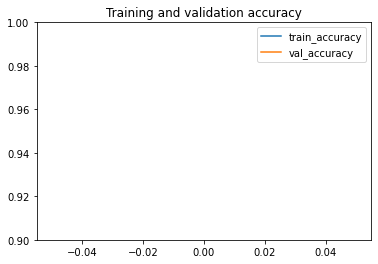

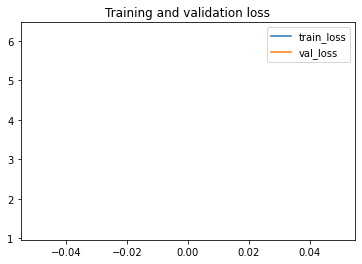

2/2 [==============================] - 3s 788ms/step - loss: 6.2653 - accuracy: 0.5532
{'loss': 6.265327453613281, 'accuracy': 0.5531914830207825}
Found 187 validated image filenames belonging to 3 classes.
Found 47 validated image filenames belonging to 1 classes.
Fold number 2
6/6 [==============================] - 19s 3s/step - loss: 1.9548 - accuracy: 0.4652 - val_loss: 7.4045 - val_accuracy: 0.3404

Epoch 00001: val_accuracy improved from -inf to 0.34043, saving model to C:/Users/user/Desktop/saved_models3\model_2.h5


C:\Users\user\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


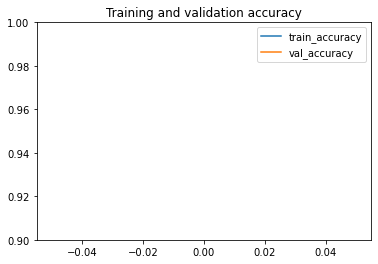

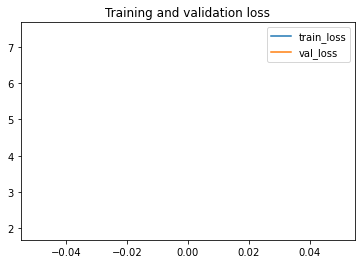

2/2 [==============================] - 3s 875ms/step - loss: 7.5996 - accuracy: 0.3830
{'loss': 7.599593639373779, 'accuracy': 0.38297873735427856}
Found 187 validated image filenames belonging to 3 classes.
Found 47 validated image filenames belonging to 2 classes.
Fold number 3
6/6 [==============================] - ETA: 0s - loss: 1.3840 - accuracy: 0.5561

InvalidArgumentError:  logits and labels must be broadcastable: logits_size=[32,3] labels_size=[32,2]
	 [[node categorical_crossentropy/softmax_cross_entropy_with_logits (defined at <ipython-input-9-3dda60245af2>:82) ]] [Op:__inference_test_function_32215]

Function call stack:
test_function


In [9]:
#initialize parameters
VALIDATION_ACCURACY = []                          #store all validation_accuracy
VALIDATION_LOSS = []                              #store all validation_loss
image_dir = directory + "/Com"                                    #where the train set images are stored
batch_size = 32                                   #batch size
fold_var = 1                                      #number of fold of the model to be called back
n = len(df)                                      #number of data in train set
num_epochs = 1                                    #number of epochs
dim = (224,224)                                   #required dimensions for process_unit (ResNet50)


#===========if exist, create new one for another set of models with new parameters======================

#directory where models per set parameters are stored
gen_dir = "C:/Users/user/Desktop"

save_cur = ""  #check if there is any saved_models folders

for x in os.listdir(gen_dir):
    if "saved_models" in x:
        #print(x)
        save_cur = x

#save_dir is where the created models using the current set of parameters are added        
        
if save_cur == "":
    save_dir = gen_dir + "/saved_models1"
    #print(save_dir)
    os.makedirs(save_dir)
else:
    save_dir = gen_dir + "/saved_models" + str(int(save_cur[-1]) + 1)
    #print(save_dir)
    os.makedirs(save_dir)

#=========================================================================================================    
    
for train_index, val_index in skf.split(np.zeros(n),Y):
    #print(train_index)
    #print(val_index)
    training_data = df.iloc[train_index]
    validation_data = df.iloc[val_index]

    train_data_generator = imgdatagen.flow_from_dataframe(training_data, directory = image_dir,
                               x_col = "filename", y_col = "label",
                              class_mode = "categorical", target_size = dim, batch_size = batch_size,
                                shuffle = True)
    valid_data_generator  = imgdatagen.flow_from_dataframe(validation_data, directory = image_dir,
                            x_col = "filename", y_col = "label",
                            class_mode = "categorical", target_size = dim, batch_size = batch_size,
                                shuffle = True)

    # CREATE NEW MODEL
    conv_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))
    for layer in conv_model.layers:
        layer.trainable = False
    x = keras.layers.Flatten()(conv_model.output)
    x = keras.layers.Dense(100, activation='relu')(x)
    x = keras.layers.Dense(100, activation='relu')(x)
    #x = keras.layers.Dense(100, activation='relu')(x)

    x = keras.layers.Dropout(0.2)(x) #to further reduce overfitting

    predictions = keras.layers.Dense(3, activation='softmax')(x)
    full_model = keras.models.Model(inputs=conv_model.input, outputs=predictions)
    
    # COMPILE NEW MODEL
    full_model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adamax(learning_rate=0.0001),
                  metrics=['accuracy']) #categorical_crossentropy cause it is more than 2 classes

    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint((save_dir+"/"+ "model_" + str(fold_var) + ".h5"), 
                            monitor='val_accuracy', verbose=1, 
                            save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
   
    print("Fold number " + str(fold_var))

    # FIT THE MODEL
    history = full_model.fit(train_data_generator,
                             epochs=num_epochs,
                             callbacks=callbacks_list,
                             validation_data=valid_data_generator)
    
    #PLOT HISTORY
    plot_history(history, yrange=(0.9,1))

    # LOAD BEST MODEL to evaluate the performance of the model
    full_model.load_weights(save_dir+"/model_"+str(fold_var)+".h5")
    
    results = full_model.evaluate(valid_data_generator)
    results = dict(zip(full_model.metrics_names,results))
    
    print(results)
    
    VALIDATION_ACCURACY.append(results['accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1    

In [ ]:
print("Validation Accuracy of All Folds:")
print(VALIDATION_ACCURACY)
print("Validation Loss of All Folds:")
print(VALIDATION_LOSS)